In [0]:
!pip install catboost  # My first aim is to use CatBoostRegressor to leverage its high computation efficiency.

In [0]:
!unzip "competitive-data-science-predict-future-sales.zip"  # I downloaded the dataset from kaggle webote in zipped format.

In [0]:
import numpy as np  
import pandas as pd   #numpy and pandas are the 2 most important libraries for Data Science.
import sklearn 
import pickle
from sklearn.metrics import mean_squared_error

In [0]:
#Loading the data into pandas dataframes
sales_train = pd.read_csv('/content/sales_train.csv.gz', compression='gzip')
shops = pd.read_csv('/content/shops.csv')
items = pd.read_csv('/content/items.csv')
item_cats = pd.read_csv('/content/item_categories.csv')
test = pd.read_csv('/content/test.csv.gz', compression = 'gzip')

In [6]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [7]:
shops.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [8]:
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [9]:
item_cats.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [10]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


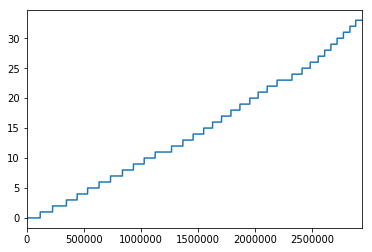

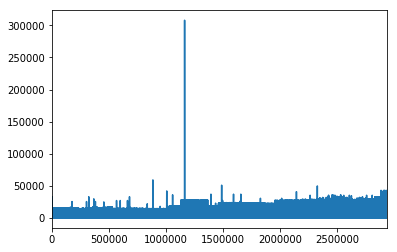

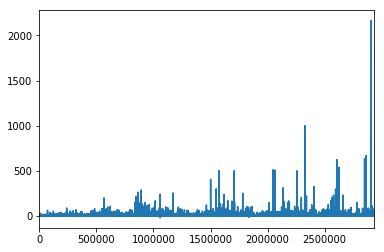

In [12]:
import matplotlib.pyplot as plt

cols = ['date_block_num', 'item_price', 'item_cnt_day']

for col in cols:
  sales_train[col].plot()
  plt.show()



In [0]:
temp = sales_train.groupby('date_block_num').aggregate({'item_cnt_day': 'sum', 'item_price':'mean'}).reset_index()

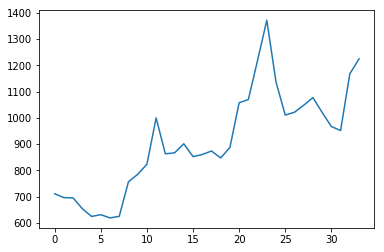

In [20]:
plt.plot(temp['date_block_num'], temp['item_price'])
plt.show()

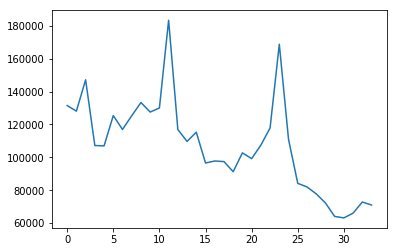

In [19]:
plt.plot(temp['date_block_num'], temp['item_cnt_day'])
plt.show()

In [0]:
del temp

The Time Series data reveals that on monthly basis, the total count of purchase decreases as time elapses and this is opposite to that of aveage item price. 

In [0]:
from tqdm import tqdm_notebook
from itertools import product
import gc

Kaggle trick to clip the upper value of 'item_cnt_day' not to 20 but to a higher value so that more predictions of 'item_cnt_day' can be obtained. So a function is defined.

In [0]:
def clip20(x):
    return np.clip(x, 0, 20)

def clip40(x):
    return np.clip(x, 0, 40)

In [0]:
# Here, this function will convert the numeric datatypes from 64bits to 32bits.
# This is done for computation efficiency and to reduce overhead on GPU RAM.

def downcast_dtypes(df):
    
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [0]:
def rmse(*args):
    
    return np.sqrt(mean_squared_error(*args))

----- **From Kaggle Dataset Description, I found out that ID column of "test" is actually a unique identification of shop_id and item_id.**

------ **The Training data has to be Aggregated so that is matches the distribution type of the Test data.**






*-------- A trick illustrated by the instructors was to append the test data to the training data and calculating some lag features.*

*-------- Our final prediction should be on a monthly basis and not on daily basis. So , the sales_train dataset has to be modified a bit.*

---> So a function is defined for this

In [0]:
def get_feature_matrix(sales, test, items, list_lags, date_block_threshold):
    
    """ This function create the model tablon"""
  
    # Creating "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    grid = [] 
    new_items = pd.DataFrame()
    cur_items_aux=np.array([])
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].append(pd.Series(cur_items_aux)).unique()
        cur_items_aux = cur_items[pd.Series(cur_items).isin(test.item_id)]
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turning the grid into a pandas dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

    # Add submission (shop_id-item_id) in order to test predictions
    test['date_block_num'] = 34 
    grid = grid.append(test[['shop_id', 'item_id', 'date_block_num']])

    # Shop-item-month aggregate
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
   
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Shop-month aggregate
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # item-month aggregate
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcasting dtypes 
     all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect()
    # List of columns to create lags
    cols_to_rename = list(all_data.columns.difference(index_cols)) 

    shift_range = list_lags

    for month_shift in tqdm_notebook(shift_range):
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

    del train_shift

    # No use of old data from year 2013
    all_data = all_data[all_data['date_block_num'] >= date_block_threshold] 

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # Category for each item
    item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

    all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    return [all_data, to_drop_cols]

***Data Leakage***
    --Around 42% of training shop_id ~ item_id pairs are present in test set.

In [0]:
df = pd.Series(list(sales_train[['item_id', 'shop_id']].itertuples(index=False, name=None)))
test_iter = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(df.isin(test_iter).sum()/len(df),2)*100)+'%')

42.0%


***Lag Features*** 

--- It is computationally ineffective on Google Colab to calculate lag for a large duration of time as the run-time crashes frequently. To keep it simple, lag duration of 1 , 2 , 3 months are taken into account.

--- Also, from Kaggle kernels  I found out that 12 months is the maximum lag obtained in this dataset by those who have latest GPU architectures. As it becomes difficult to calculate huge lags on Colab, I will take the Kaggle Discussion as prima facie.

In [0]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_modelling = sales_train[sales_train.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = get_feature_matrix(sales_modelling, test, items, list_lags, date_block_threshold)

***Encoding***

------  In the course, one of the instructors had mentioned about mean encoding  and variance encoding as a powerful technique for obtaining good results.

In [0]:
mean_enc_item_cat = pd.DataFrame(all_data.groupby(['shop_id', 
                                                    'item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']
all_data = pd.merge(all_data, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
del mean_enc_item_cat
all_data = downcast_dtypes(all_data)

Train/Valid/Test Split

In [0]:
sub_data = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)

In [0]:
dates = all_data['date_block_num']
boolean_test = (dates.isin([22,31,32,33]))  # My random choice
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

In [0]:
X_train.nunique()

shop_id                54
item_id              4045
target_lag_1          344
target_item_lag_1     579
target_shop_lag_1     705
target_lag_2          351
target_item_lag_2     591
target_shop_lag_2     700
target_lag_3          348
target_item_lag_3     597
target_shop_lag_3     688
item_category_id       58
mean_enc_cat_id      2143
var_enc_cat_id       2354
dtype: int64

Here, these datasets are saved so as to use them for hyperparameter optimization outside this notebook.

In [0]:
pd.DataFrame(X_train).to_csv('X_train.csv')
pd.DataFrame(X_val).to_csv('X_val.csv')
pd.DataFrmae(y_train).to_csv('y_train.csv')
pd.DataFrame(y_val).to_csv('y_val.csv')
sub_data.to_csv('sub_data.csv')

### CatBoost###

CatBoost is a very powerful and fast Boosting Library for Boosted(Ordered) trees. It is much faster than XGBoost and LightGBM. CatBoost works best with categorical features. 

X_train has no categorical features but from intuition it can be said that shop_id and item_category_id can be considered as categories. There are over 4000 unique values in item_id, so it is better not to consider it as a categorical feature.

I am just checking whether the CatBoost performs well or not.

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    iterations=800,
    random_seed=2**7,
    learning_rate=0.05,
    od_type ='Iter',
    od_wait = 20,
    eval_metric = 'RMSE',
    verbose = 50,
    task_type='GPU',
    )

In [0]:
model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=['shop_id', 'item_category_id'])

0:	learn: 4.3528630	test: 4.3695294	best: 4.3695294 (0)	total: 29.3ms	remaining: 23.4s
50:	learn: 2.5057464	test: 3.3448218	best: 3.3448218 (50)	total: 994ms	remaining: 14.6s
100:	learn: 2.3081386	test: 3.2590365	best: 3.2590365 (100)	total: 1.87s	remaining: 12.9s
150:	learn: 2.2085357	test: 3.2246747	best: 3.2246747 (150)	total: 2.77s	remaining: 11.9s
200:	learn: 2.1457046	test: 3.2105307	best: 3.2105307 (200)	total: 3.69s	remaining: 11s
250:	learn: 2.1007604	test: 3.1949214	best: 3.1949214 (250)	total: 4.61s	remaining: 10.1s
300:	learn: 2.0621028	test: 3.1812785	best: 3.1811165 (295)	total: 5.52s	remaining: 9.15s
350:	learn: 2.0305116	test: 3.1696874	best: 3.1693821 (345)	total: 6.43s	remaining: 8.23s
400:	learn: 2.0059072	test: 3.1617089	best: 3.1614303 (397)	total: 7.36s	remaining: 7.32s
bestTest = 3.159271657
bestIteration = 412
Shrink model to first 413 iterations.


I tried a lot of tuning of the parameters of CatBoost but to no avail. The minimum rmse on validation set was obtained to be 1.0005 after optimization and the optimized model scored 5/10 on Coursera grader with public/private score of 0.998 and 1.002.

---------------------------------
So, CatBoost can give us the best results in the presence of high cardinality categorical features as opposed to our case.
 So, I shall drop CatBoost

### LightGBM

Using LightGBM is better than XGBOOST due to speed and memory overhead issues. 

The only problem using LightGBM is that Colab has to be configured properly to set up GPU for LightGBM.
On the other hand, XGBOOST can directly comply with GPU settings once runtime is set to GPU type.

In [0]:
import  lightgbm as lgb

In [0]:
X = X_train.append(X_val)
y = np.append(y_train, y_val)

I have run certain hyperparameter tuning using hyperopt package. It took a very very long time to find a considerably optimal set of hyperparameters for lightgbm. Here, the best parameters are used.

In [0]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.05, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0,
               
              }
lgb = lgb.train(lgb_params, lgb.Dataset(X, label=clip40(y)), int(100 * (0.05 / 0.03)))

### Random Forest

RandomForest is one of the best algorithms available. It is a highly customizable model that can run easily on a GPU or a CPU(using parallel construction of tress).  I wil use RandomForest as my 2nd model.

In [0]:
rf = RandomForestRegressor(bootstrap=0.7, criterion='mse', max_depth=12,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

I have clipped the output display as it was very long.

In [0]:
rf.fit(X, clip40(y))

In [0]:
pickle.dump(rf, open('/content/best_rf.sav', 'wb'))

In [0]:
pickle.dump(lgb,open('/content/best_lgb.sav', "wb"))

The best_lgb file is 3.25 MB and best_rf file is 104.37 MB in size. 

In [0]:
pred_lgb_val = clip20(lgb.predict(X_val))

In [0]:
pred_rf_val = clip20(rf.predict(X_val.fillna(0)))

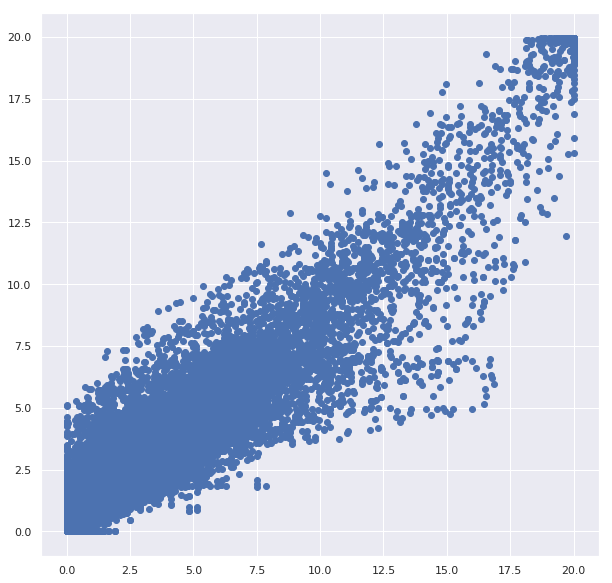

In [0]:
plt.scatter(pred_lgb_val, pred_rf_val)
plt.show()

The predictions of the RandomForest and LightGBM are linearly very close and seem to have a good positive correlation.

In [0]:
pred_lgb_test = lgb.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))

In [0]:
test['item_cnt_month'] = pred_lgb_test
test.drop(['shop_id', 'item_id', 'date_block_num'], axis=1, inplace=True)
test.to_csv('/content/submission1.csv', index=False)

In [0]:
pred_rf_test = rf.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))

In [0]:
test['item_cnt_month'] = pred_rf_test
test.to_csv('/content/submission2.csv', index=False)

In [0]:
test.head()

,ID,item_cnt_month
0,0,0.540512
1,1,0.642425
2,2,0.959606
3,3,0.463816
4,4,3.191360


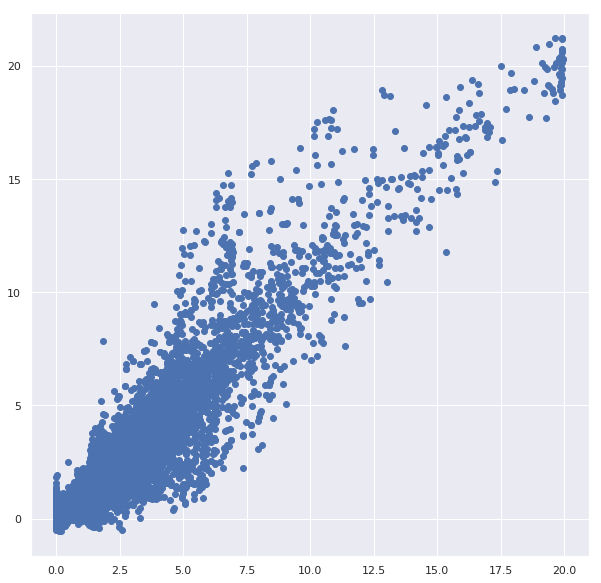

In [0]:
plt.scatter(pred_rf_test, pred_lgb_test)
plt.show()

I submitted both the models' predictions and both the submissions scored 10/10. The Private Leader Board Score of the Random Forest model was 0.9212 and for the LightGBM model it was 0.9369.  Here, RandomForest seems to outperform LightGBM.

I had also used stacking on both these models but the predictions scored 8/10 on the coursera leader board.